In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect , desc , text

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measurement= Base.classes.measurement
station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24bafe9cf10>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
# session.query(func.max(measurement.date)).scalar()
one_year_eariler = session.query(func.date(func.date('2017-08-23'), '-365 days')).scalar()
one_year_eariler

'2016-08-23'

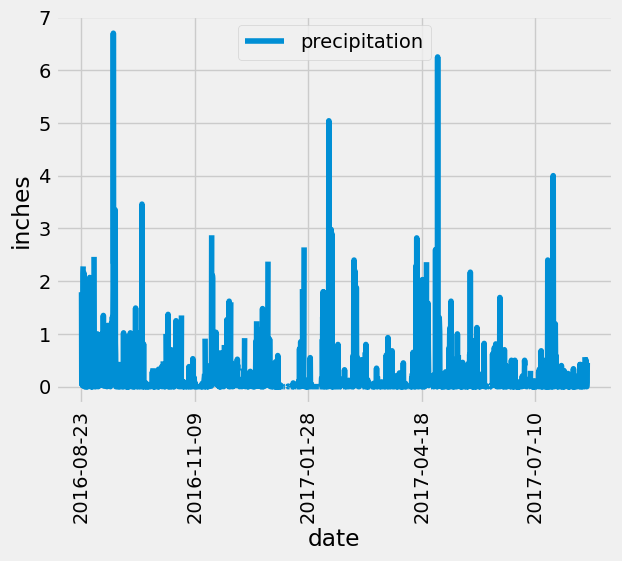

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_eariler = session.query(func.date(func.date("2017-08-23"), "-365 days")).scalar()

# Perform a query to retrieve the data and precipitation scores
filtered = session.query(measurement.date, measurement.prcp) \
    .filter(measurement.date >= one_year_eariler) \
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["date", "precipitation"]
filtered_df = pd.DataFrame(filtered, columns=column_names)
# filtered_df

# Sort the dataframe by date
filtered_df_sorted = filtered_df.sort_values(by="date")
filtered_df_sorted.head()

# Use Pandas Plotting with Matplotlib to plot the data
filtered_df_sorted.plot(kind="line", x="date", y="precipitation",rot=90)
plt.xlabel("date")
plt.ylabel("inches")
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summery = filtered_df_sorted.describe()
summery

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24bafe9c280>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [30]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
total_stations

[(9,)]

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all() 

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(measurement.tobs))\
    .filter(measurement.station == "USC00519281").scalar()

highest_temp = session.query(func.max(measurement.tobs))\
    .filter(measurement.station == "USC00519281").scalar()

avg_temp = session.query(func.avg(measurement.tobs))\
    .filter(measurement.station == "USC00519281").scalar()

temps = [lowest_temp, highest_temp, avg_temp]
print(temps)

[54.0, 85.0, 71.66378066378067]


<function matplotlib.pyplot.show(close=None, block=None)>

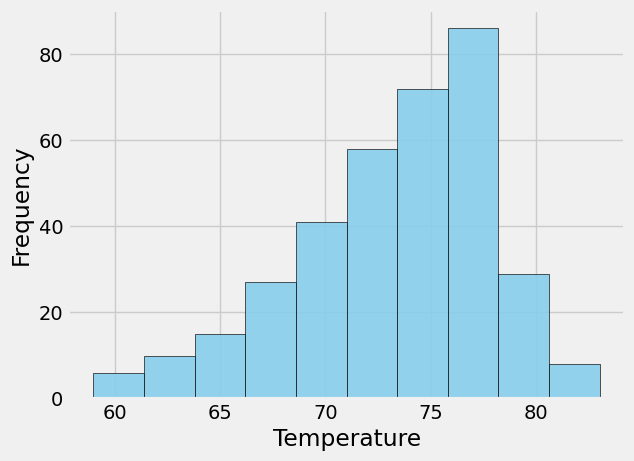

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
unique_id = session.query(measurement.tobs, measurement.date).\
    filter(measurement.station == "USC00519281").\
    filter(measurement.date >= one_year_eariler).\
    all()

column_names_id = ["temperature", "date"]
filtered_id_df = pd.DataFrame(unique_id, columns=column_names_id)
filtered_id_df_rows = filtered_id_df["temperature"].values

plt.hist(filtered_id_df_rows,  color='skyblue', edgecolor='black', alpha=0.9)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show

# Close Session

In [34]:
# Close Session
session.close()